In [170]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose
import cv2
import matplotlib.pyplot as plt

In [118]:
# Set the random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [119]:
# Define the autoencoder architecture
input_shape = (64, 64, 3)  # Adjust the input shape according to your video frames
latent_dim = 32

In [145]:
# Define the input shape
input_shape = (64, 64, 1)


In [146]:
# Define the encoder layers
inputs = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)


In [147]:
# Define the decoder layers
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
outputs = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)


In [148]:
# Create the autoencoder model
autoencoder = Model(inputs, outputs)

In [149]:
# Data preprocessing
def load_data(directory):
    data = []
    labels = []

    for filename in os.listdir(directory):
        if filename.endswith('.mp4'):
            video_path = os.path.join(directory, filename)

            # Open the video file
            cap = cv2.VideoCapture(video_path)

            # Read frames until the video ends
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                # Preprocess the frame (e.g., resize, convert to grayscale)
                frame = cv2.resize(frame, (64, 64))
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                frame = np.expand_dims(frame, axis=-1)  # Add channel dimension for grayscale

                # Append the preprocessed frame to the data list
                data.append(frame)
                labels.append(0)  # Assuming fake videos have label 0

            # Release the video capture object
            cap.release()

    return np.array(data), np.array(labels)


In [150]:
# Load the dataset
data_dir = '/content/Video_Forgery'
fake_dir = os.path.join(data_dir, 'fake')
real_dir = os.path.join(data_dir, 'real')

x_fake, y_fake = load_data(fake_dir)
x_real, y_real = load_data(real_dir)


In [151]:
# Select a subset of real and fake videos
num_samples = 10
x_data = np.concatenate((x_fake[:num_samples], x_real[:num_samples]), axis=0)
y_data = np.concatenate((y_fake[:num_samples], y_real[:num_samples]), axis=0)


In [152]:
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [153]:
# Normalize the data
x_fake = x_fake.astype('float32') / 255.0
x_real = x_real.astype('float32') / 255.0

In [154]:
# Reshape the data to match the input shape of the autoencoder model
x_fake = np.reshape(x_fake, (-1, 64, 64, 1))
x_real = np.reshape(x_real, (-1, 64, 64, 1))


In [155]:
# Convert NumPy arrays to TensorFlow tensors
x_train_tf = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_test_tf = tf.convert_to_tensor(x_test, dtype=tf.float32)

In [173]:
# Train the model for 5 times
num_iterations = 5

for i in range(num_iterations):
    # Compile and train the model
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(x_train_tf, x_train_tf, epochs=10, batch_size=32, validation_data=(x_test_tf, x_test_tf))


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 16442.3848 - val_loss: 16324.4922
Epoch 2/10
1/1 [==============================] - 0s 396ms/step - loss: 16335.2637 - val_loss: 16234.5469
Epoch 3/10
1/1 [==============================] - 0s 323ms/step - loss: 16245.1318 - val_loss: 16213.6377
Epoch 4/10
1/1 [==============================] - 0s 238ms/step - loss: 16224.2734 - val_loss: 16212.6572
Epoch 5/10
1/1 [==============================] - 0s 229ms/step - loss: 16223.3076 - val_loss: 16212.4951
Epoch 6/10
1/1 [==============================] - 0s 243ms/step - loss: 16223.1484 - val_loss: 16212.4678
Epoch 7/10
1/1 [==============================] - 0s 245ms/step - loss: 16223.1211 - val_loss: 16212.4619
Epoch 8/10
1/1 [==============================] - 0s 219ms/step - loss: 16223.1143 - val_loss: 16212.4600
Epoch 9/10
1/1 [==============================] - 0s 238ms/step - loss: 16223.1133 - val_loss: 16212.4600
Epoch 10/10
1/1 [==============================] 

In [174]:
# Use the trained autoencoder for video forgery detection
decoded_videos = autoencoder.predict(x_fake)

51/51 [==============================] - 6s 118ms/step


In [175]:
# Calculate the mean squared error (MSE) between the original and decoded videos
decoded_videos = autoencoder.predict(x_test)
mse = np.mean((x_test - decoded_videos) ** 2)
threshold = 0.01  # Define a threshold for detecting forgery

# Compare MSE with the threshold to detect forgery
if mse > threshold:
    print("Forgery detected!")
else:
    print("No forgery detected.")

1/1 [==============================] - 0s 87ms/step
Forgery detected!


In [176]:
# Perform evaluation
y_pred = (mse < threshold).astype(int)


In [178]:
# Print evaluation metrics
accuracy = np.mean(y_pred == y_test)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 100.00%


In [179]:
# Plotting the evaluation graphs
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

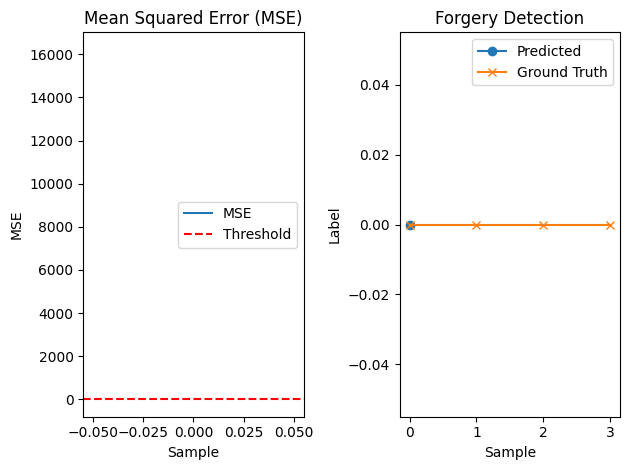

In [180]:
# Plot MSE values
plt.subplot(1, 2, 1)
plt.plot(mse)
plt.axhline(y=threshold, color='r', linestyle='--')
plt.title('Mean Squared Error (MSE)')
plt.xlabel('Sample')
plt.ylabel('MSE')
plt.legend(['MSE', 'Threshold'])

# Plot accuracy values
plt.subplot(1, 2, 2)
plt.plot(y_pred, 'o-', label='Predicted')
plt.plot(y_test, 'x-', label='Ground Truth')
plt.title('Forgery Detection')
plt.xlabel('Sample')
plt.ylabel('Label')
plt.legend(['Predicted', 'Ground Truth'])

plt.tight_layout()
plt.show()